In [ ]:
# !pip install pymupdf
# !pip install spacy
# !python -m spacy download ru_core_news_sm
# !pip install rank-bm25

In [43]:
import fitz
import re
import spacy
import string
from rank_bm25 import BM25Okapi

In [44]:
pdf_path = "data/constitution_rf.pdf"
def read_pdf(pdf_path):
    doc = fitz.open(pdf_path)
    full_text = "\n".join([page.get_text() for page in doc])

    
    full_text = re.sub(r"<.*?>", "", full_text)
    full_text = re.sub(r"[ \t]+", " ", full_text)  
    full_text = full_text.strip().replace('\n', ' ')
    article_pattern = re.compile(r"(Статья \d+)", re.MULTILINE)

    articles = article_pattern.split(full_text)

    article_dict = {}

    for i in range(1, len(articles), 2): 
        article_title = articles[i].strip()
        article_body = articles[i + 1].strip()
        
        points = re.split(r"\d+\.\s", article_body)
        
        points = [f"{idx-1}. {p.strip()}" if idx > 1 else f"{p.strip()}" for idx, p in enumerate(points, start=1) if p.strip()]
        
        article_dict[article_title] = points
    return article_dict

article_dict = dict(read_pdf(pdf_path))
for article, points in list(article_dict.items())[100:105]: 
    print(f"\n{article}:")
    for p in points:
        print(f"{p}")


Статья 101:
1. Совет Федерации избирает из своего состава Председателя Совета Федерации и его заместителей. Государственная Дума избирает из своего состава Председателя Государственной Думы и его заместителей.
2. Председатель Совета Федерации и его заместители, Председатель Государственной Думы и его заместители ведут заседания и ведают внутренним распорядком палаты.
3. Совет Федерации и Государственная Дума образуют комитеты и комиссии, проводят по вопросам своего ведения парламентские слушания.
4. Каждая из палат принимает свой регламент и решает вопросы внутреннего распорядка своей деятельности.
5. Для осуществления контроля за исполнением федерального бюджета Совет Федерации и Государственная Дума образуют Счетную палату, состав и порядок деятельности которой определяются федеральным законом.

Статья 102:
1. К ведению Совета Федерации относятся: а) утверждение изменения границ между субъектами Российской Федерации; б) утверждение указа Президента Российской Федерации о введении во

In [45]:
nlp = spacy.load("ru_core_news_sm")

def clean_and_lemmatize(text):
    text = text.lower().strip().replace("\n", " ") 
    text = re.sub(r"\s+", " ", text) 
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation)) 
    doc = nlp(text)
    return [token.lemma_ for token in doc if not token.is_stop and token.lemma_.strip()]

def create_lemma_dict():
    lemmatized_article_dict = {
        key: [clean_and_lemmatize(p) for p in points if p.strip()] 
        for key, points in article_dict.items()
    }
    return lemmatized_article_dict

lemmatized_article_dict = create_lemma_dict()



In [46]:
for article, points in list(lemmatized_article_dict.items())[100:105]: 
    print(f"\n{article}:")
    for p in points:
        print(f"{p}")
        
print(lemmatized_article_dict)


Статья 101:
['совет', 'федерация', 'избирать', 'состав', 'председатель', 'совет', 'федерация', 'заместитель', 'государственный', 'дума', 'избирать', 'состав', 'председатель', 'государственный', 'дума', 'заместитель']
['председатель', 'совет', 'федерация', 'заместитель', 'председатель', 'государственный', 'дума', 'заместитель', 'вести', 'заседание', 'ведать', 'внутренний', 'распорядок', 'палата']
['совет', 'федерация', 'государственный', 'дума', 'образовать', 'комитет', 'комиссия', 'проводить', 'вопрос', 'ведение', 'парламентский', 'слушание']
['палата', 'принимать', 'регламент', 'решать', 'вопрос', 'внутренний', 'распорядок', 'деятельность']
['осуществление', 'контроль', 'исполнение', 'федеральный', 'бюджет', 'совет', 'федерация', 'государственный', 'дума', 'образовать', 'счётный', 'палата', 'состав', 'порядок', 'деятельность', 'определяться', 'федеральный', 'закон']

Статья 102:
['ведение', 'совет', 'федерация', 'относиться', 'утверждение', 'изменение', 'граница', 'субъект', 'российс

In [47]:
corpus = [" ".join([" ".join(p) for p in points]) for points in lemmatized_article_dict.values()]
tokenized_corpus = [doc.split() for doc in corpus] 

bm25 = BM25Okapi(tokenized_corpus)

def search_bm25(query, top_n=3):
    query = query.strip()

    if query.lower().startswith("статья"):
        if query in article_dict:
            return [(query, " ".join(article_dict[query]))]
        else:
            return [("Ошибка", f"Статья '{query}' не найдена")]
    
    
    query_tokens = clean_and_lemmatize(query)  
    scores = bm25.get_scores(query_tokens)  
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n] 
    top_articles = list(lemmatized_article_dict.keys()) 
    
    results = []
    for i in top_indexes:
        article_title = top_articles[i]
        original_text = "\n".join(article_dict[article_title]) 
        results.append((article_title, original_text))
    
    return results

queries = ["Права человека"]
for query in queries:
    results = search_bm25(query)
    print(f"\nЗапрос: {query}")
    for title, text in results:
        print(f"\n{title}:\n{text}")  



Запрос: Права человека

Статья 17:
1. В Российской Федерации признаются и гарантируются права и свободы человека и гражданина согласно общепризнанным принципам и нормам международного права и в соответствии с настоящей Конституцией.
2. Основные права и свободы человека неотчуждаемы и принадлежат каждому от рождения.
3. Осуществление прав и свобод человека и гражданина не должно нарушать права и свободы других лиц.

Статья 2:
Человек, его права и свободы являются высшей ценностью. Признание, соблюдение и защита прав и свобод человека и гражданина - обязанность государства.

Статья 55:
1. Перечисление в Конституции Российской Федерации основных прав и свобод не должно толковаться как отрицание или умаление других общепризнанных прав и свобод человека и гражданина.
2. В Российской Федерации не должны издаваться законы, отменяющие или умаляющие права и свободы человека и гражданина.
3. Права и свободы человека и гражданина могут быть ограничены федеральным законом только в той мере, в как

### Часть 2 

In [9]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import os
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity


d:\pypy\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# Папка для сохранения
data_dir = "D:/pypy/pdf_search/images"

# Загружаем CIFAR-10 (размер ~160MB)
dataset = datasets.CIFAR10(root=data_dir, download=True, transform=transforms.ToTensor())

print("CIFAR-10 скачан и сохранён в", data_dir)


100%|██████████| 170M/170M [00:09<00:00, 17.1MB/s] 


Extracting D:/pypy/pdf_search/images\cifar-10-python.tar.gz to D:/pypy/pdf_search/images
CIFAR-10 скачан и сохранён в D:/pypy/pdf_search/images


In [ ]:
# Папка для сохранения изображений
save_dir = "./cifar10_images"
os.makedirs(save_dir, exist_ok=True)

# Загружаем CIFAR-10
dataset = datasets.CIFAR10(root="D:/pypy/pdf_search/images", train=True, download=True)

# Сохраняем изображения в виде PNG
for i, (image, label) in enumerate(dataset):
    class_dir = os.path.join(save_dir, str(label))  # Создаём папку для класса
    os.makedirs(class_dir, exist_ok=True)
    
    image_path = os.path.join(class_dir, f"{i}.png")
    image.save(image_path)

print(f"Изображения сохранены в {save_dir}")


Files already downloaded and verified
Изображения сохранены в ./cifar10_images


In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [123]:
# Загружаем модель CLIP
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Пути к изображениям
custom_images_path = "D:/pypy/pdf_search/images"
cifar10_path = "D:/pypy/pdf_search/cifar10_images"

In [21]:
for i in article_dict.items():
    article_dict[i[0]] = ' '.join(i[1])
    
print(article_dict)

{'Статья 1': '1. Российская Федерация - Россия есть демократическое федеративное правовое государство с республиканской формой правления. 2. Наименования Российская Федерация и Россия равнозначны.', 'Статья 2': 'Человек, его права и свободы являются высшей ценностью. Признание, соблюдение и защита прав и свобод человека и гражданина - обязанность государства.', 'Статья 3': '1. Носителем суверенитета и единственным источником власти в Российской Федерации является ее многонациональный народ. 2. Народ осуществляет свою власть непосредственно, а также через органы государственной власти и органы местного самоуправления. 3. Высшим непосредственным выражением власти народа являются референдум и свободные выборы. 4. Никто не может присваивать власть в Российской Федерации. Захват власти или присвоение властных полномочий преследуются по федеральному закону.', 'Статья 4': '1. Суверенитет Российской Федерации распространяется на всю ее территорию. 2. Конституция Российской Федерации и федераль

In [ ]:
# Функция для загрузки изображений и их векторизации через CLIP
def process_images(image_dirs):
    print('картинки')
    image_embeddings = []
    image_paths = []

    for img_dir in image_dirs:
        for root, _, files in os.walk(img_dir):
            for file in files:
                if file.endswith((".jpg", ".jpeg", ".png")):
                    img_path = os.path.join(root, file)
                    try:
                        image = Image.open(img_path).convert("RGB")
                        inputs = processor(images=image, return_tensors="pt").to(device)

                        with torch.no_grad():
                            img_embedding = model.get_image_features(**inputs).cpu().numpy().flatten()
                        
                        image_embeddings.append(img_embedding)
                        image_paths.append(img_path)
                    except Exception as e:
                        print(f"Ошибка обработки {img_path}: {e}")

    return np.array(image_embeddings), image_paths

# Функция для векторизации текста через CLIP
def encode_texts(article_dict):
    print('текст')
    text_embeddings = []
    article_texts = []
    article_titles = []

    for title, text in article_dict.items():
              # Усечение текста до максимальной длины (77 токенов для CLIP)
        inputs = processor(text=[text], return_tensors="pt", padding=True, truncation=True, max_length=77).to(device)
        
        with torch.no_grad():
            text_embedding = model.get_text_features(**inputs).cpu().numpy().flatten()
        
        text_embeddings.append(text_embedding)
        article_texts.append(text)
        article_titles.append(title)

    return np.array(text_embeddings), article_titles, article_texts

# Векторизуем тексты и изображения
text_embeddings, article_titles, article_texts = encode_texts(article_dict)
image_embeddings, image_paths = process_images([custom_images_path, cifar10_path])

текст
картинки
CSV-файл сохранён!


In [ ]:
# Сопоставляем статьи с изображениями по косинусному сходству
# best_images = []
# for text_emb in text_embeddings:
#     similarities = cosine_similarity([text_emb], image_embeddings)[0]
#     best_match_idx = similarities.argmax()
#     best_images.append(image_paths[best_match_idx])

# # Создаём DataFrame и сохраняем в CSV
# df = pd.DataFrame({
#     "Статья": article_titles,
#     "Текст статьи": article_texts,
#     "Код_эмбеддинг_CLIP": [emb.tolist() for emb in text_embeddings],
#     "Путь к подходящей картинке": best_images
# })

# df.to_csv("D:/pypy/pdf_search/articles_with_images.csv", index=False, encoding="utf-8")
# print("CSV-файл сохранён!")

Учитывая датасет CIFAR и 24 картинки, которые я подобрал, для 120 статей, была выбрано просто фотография конституции

In [55]:
from collections import defaultdict
import random
# Счётчик использований картинок
image_counter = defaultdict(int)
max_usage = 25  # Максимальное количество использований одной картинки

# Сопоставляем статьи с изображениями по косинусному сходству
best_images = []
for text_emb in text_embeddings:
    similarities = cosine_similarity([text_emb], image_embeddings)[0]
    top_5_indices = similarities.argsort()[-5:][::-1]  # Топ-5 индексов
    
    for idx in top_5_indices:
        if image_counter[image_paths[idx]] < max_usage:
            best_images.append(image_paths[idx])
            image_counter[image_paths[idx]] += 1
            break
    else:
        # Если все картинки из топ-5 использованы максимальное количество раз, выбираем случайную
        best_images.append(random.choice(image_paths))

# Создаём DataFrame и сохраняем в CSV
df = pd.DataFrame({
    "Статья": article_titles,
    "Текст статьи": article_texts,
    "Код_эмбеддинг_CLIP": [emb.tolist() for emb in text_embeddings],
    "Путь к подходящей картинке": best_images
})

df.to_csv("D:/pypy/pdf_search/articles_with_images.csv", index=False, encoding="utf-8")
print("CSV-файл сохранён!")

CSV-файл сохранён!


In [54]:
df["Путь к подходящей картинке"].value_counts()

Путь к подходящей картинке
D:/pypy/pdf_search/images\st_1.jpg      25
D:/pypy/pdf_search/images\st_15.jpeg    25
D:/pypy/pdf_search/images\st_5.jpg      25
D:/pypy/pdf_search/images\st_59.jpg     25
D:/pypy/pdf_search/images\st_14.jpg     18
D:/pypy/pdf_search/images\st_2.jpg       8
D:/pypy/pdf_search/images\st_70.jpg      3
D:/pypy/pdf_search/images\st_95.jpeg     2
D:/pypy/pdf_search/images\st_57.jpg      2
D:/pypy/pdf_search/images\st_96.jpg      2
D:/pypy/pdf_search/images\st_80.jpg      1
D:/pypy/pdf_search/images\st_75.jpg      1
Name: count, dtype: int64

Ограничев максимальное кол-во, выглядит вся таки так поинтереснее. Из Cifar все равно не попала ни одна картинка, но они и врядли подходят по тематике, да и возможно сыграла роль их маленькое разрешение по сравнению со скаченными 

In [70]:
df.iloc[80]['Путь к подходящей картинке']

'D:/pypy/pdf_search/images\\st_1.jpg'


Запрос: Статья 15

Статья 15:
1. Конституция Российской Федерации имеет высшую юридическую силу, прямое действие и применяется на всей территории Российской Федерации. Законы и иные правовые акты, принимаемые в Российской Федерации, не должны противоречить Конституции Российской Федерации. 2. Органы государственной власти, органы местного самоуправления, должностные лица, граждане и их объединения обязаны соблюдать Конституцию Российской Федерации и законы. 3. Законы подлежат официальному опубликованию. Неопубликованные законы не применяются. Любые нормативные правовые акты, затрагивающие права, свободы и обязанности человека и гражданина, не могут применяться, если они не опубликованы официально для всеобщего сведения. 4. Общепризнанные принципы и нормы международного права и международные договоры Российской Федерации являются составной частью ее правовой системы. Если международным договором Российской Федерации установлены иные правила, чем предусмотренные законом, то применяются 

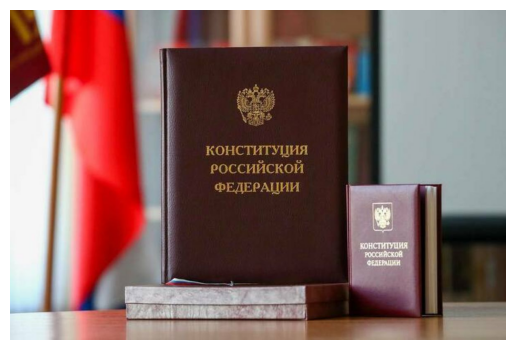

16
1
54

Запрос: Прача человека

Статья 17:
1. В Российской Федерации признаются и гарантируются права и свободы человека и гражданина согласно общепризнанным принципам и нормам международного права и в соответствии с настоящей Конституцией.
2. Основные права и свободы человека неотчуждаемы и принадлежат каждому от рождения.
3. Осуществление прав и свобод человека и гражданина не должно нарушать права и свободы других лиц.


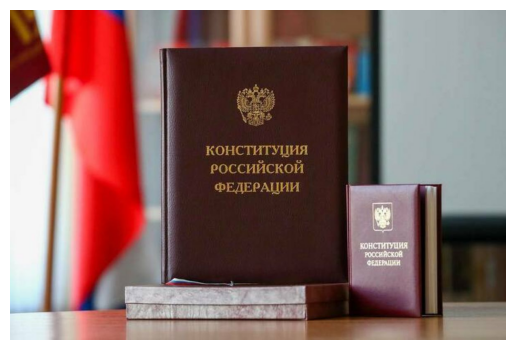


Статья 2:
Человек, его права и свободы являются высшей ценностью. Признание, соблюдение и защита прав и свобод человека и гражданина - обязанность государства.


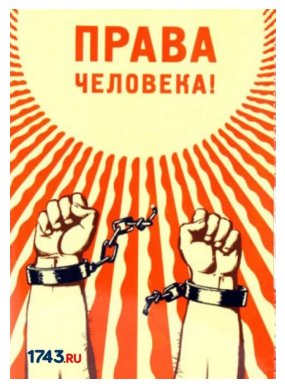


Статья 55:
1. Перечисление в Конституции Российской Федерации основных прав и свобод не должно толковаться как отрицание или умаление других общепризнанных прав и свобод человека и гражданина.
2. В Российской Федерации не должны издаваться законы, отменяющие или умаляющие права и свободы человека и гражданина.
3. Права и свободы человека и гражданина могут быть ограничены федеральным законом только в той мере, в какой это необходимо в целях защиты основ конституционного строя, нравственности, здоровья, прав и законных интересов других лиц, обеспечения обороны страны и безопасности государства.


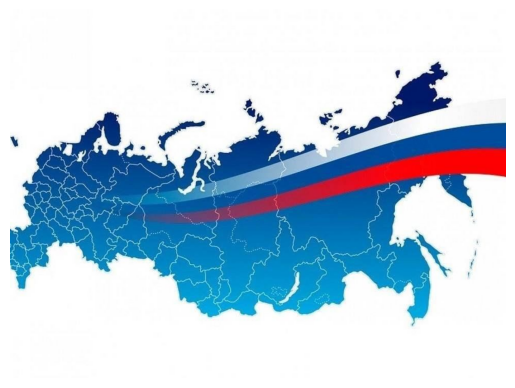

In [82]:
# Тест поиска
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Загрузка и вывод картинки

def search_bm25(query, top_n=3):
    query = query.strip()

    if query.lower().startswith("статья"):
        if query in article_dict:
            return [(query, " ".join(article_dict[query]), df.iloc[int(query[7:])]['Путь к подходящей картинке'])]
        else:
            return [("Ошибка", f"Статья '{query}' не найдена")]
    
    
    query_tokens = clean_and_lemmatize(query)  
    scores = bm25.get_scores(query_tokens)  
    top_indexes = sorted(range(len(scores)), key=lambda i: scores[i], reverse=True)[:top_n] 
    top_articles = list(lemmatized_article_dict.keys()) 
    
    results = []
    for i in top_indexes:
        print(i)
        article_title = top_articles[i]
        original_text = "\n".join(article_dict[article_title])
        image = df.iloc[i]['Путь к подходящей картинке'] 
        results.append((article_title, original_text, image))
    
    return results

queries = ["Статья 15", "Прача человека"]
for query in queries:
    results = search_bm25(query)
    print(f"\nЗапрос: {query}")
    for title, text, image_path in results:
        print(f"\n{title}:\n{text}")
        img = mpimg.imread(image_path)
        plt.imshow(img)
        plt.axis("off")  # Скрыть оси
        plt.show() 

In [ ]:
# теперь сделаем поиск по картинкаим 
# !pip install faiss-cpu

In [84]:
def encode_image(img_path):
    image = Image.open(img_path).convert("RGB")
    inputs = processor(images=image, return_tensors="pt").to(device)

    with torch.no_grad():
        img_embedding = model.get_image_features(**inputs).cpu().numpy().flatten()
    
    return img_embedding

In [106]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def search_by_image_sklearn(image_path, top_n=3):
    # Векторизация загруженной картинки
    image_embedding = encode_image(image_path).reshape(1, -1)
    
    # Загрузка текстовых эмбеддингов из DataFrame
    text_embeddings = np.array(df["Код_эмбеддинг_CLIP"].tolist())
    
    # Вычисление косинусного сходства
    similarities = cosine_similarity(image_embedding, text_embeddings)[0]
    
    # Получение индексов топ-N статей
    top_indexes = similarities.argsort()[-top_n:][::-1]
    
    # Формирование результатов
    results = []
    for idx in top_indexes:
        article_title = df.iloc[idx]["Статья"]
        article_text = df.iloc[idx]["Текст статьи"]
        article_image_path = df.iloc[idx]["Путь к подходящей картинке"]
        results.append((article_title, article_text, article_image_path, similarities[idx]))
    
    return results


Результаты поиска по картинке (sklearn):

Статья 38 (сходство: 0.19):
1. Материнство и детство, семья находятся под защитой государства. 2. Забота о детях, их воспитание - равное право и обязанность родителей. 3. Трудоспособные дети, достигшие 18 лет, должны заботиться о нетрудоспособных родителях.


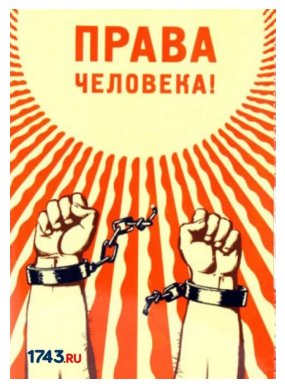


Статья 50 (сходство: 0.19):
1. Никто не может быть повторно осужден за одно и то же преступление. 2. При осуществлении правосудия не допускается использование доказательств, полученных с нарушением федерального закона. 3. Каждый осужденный за преступление имеет право на пересмотр приговора вышестоящим судом в порядке, установленном федеральным законом, а также право просить о помиловании или смягчении наказания.


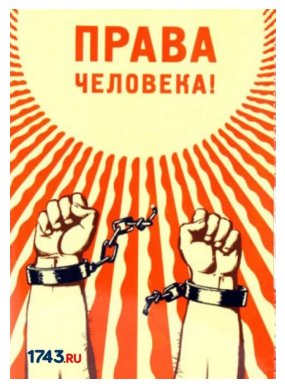


Статья 99 (сходство: 0.18):
1. Федеральное Собрание является постоянно действующим органом. 2. Государственная Дума собирается на первое заседание на тридцатый день после избрания. Президент Российской Федерации может созвать заседание Государственной Думы ранее этого срока. 3. Первое заседание Государственной Думы открывает старейший по возрасту депутат. 4. С момента начала работы Государственной Думы нового созыва полномочия Государственной Думы прежнего созыва прекращаются.


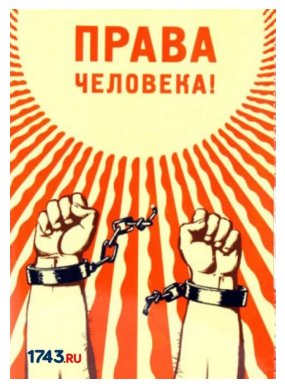

In [ ]:
# Путь к загруженной картинке
user_image_path = "D:/pypy/pdf_search/test3.jpg"  

# Поиск статей по картинке с использованием sklearn
results = search_by_image_sklearn(user_image_path)

# Вывод результатов
print("\nРезультаты поиска по картинке (sklearn):")
for title, text, image_path, similarity in results:
    print(f"\n{title} (сходство: {similarity:.2f}):\n{text}")
    if image_path:
        try:
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.axis("off")  # Скрыть оси
            plt.show()
        except FileNotFoundError:
            print(f"Ошибка: Картинка по пути '{image_path}' не найдена.")
        except Exception as e:
            print(f"Ошибка при загрузке картинки: {e}")
    else:
        print("Картинка не найдена")

при поиске по фото с человеком в костюме получили результаты, где до этого выбралась картинка с правами человека


Результаты поиска по картинке (sklearn):

Статья 5 (сходство: 0.24):
1. Российская Федерация состоит из республик, краев, областей, городов федерального значения, автономной области, автономных округов - равноправных субъектов Российской Федерации. 2. Республика (государство) имеет свою конституцию и законодательство. Край, область, город федерального значения, автономная область, автономный округ имеет свой устав и законодательство. 3. Федеративное устройство Российской Федерации основано на ее государственной целостности, единстве системы государственной власти, разграничении предметов ведения и полномочий между органами государственной власти Российской Федерации и органами государственной власти субъектов Российской Федерации, равноправии и самоопределении народов в Российской Федерации. 4. Во взаимоотношениях с федеральными органами государственной власти все субъекты Российской Федерации между собой равноправны.


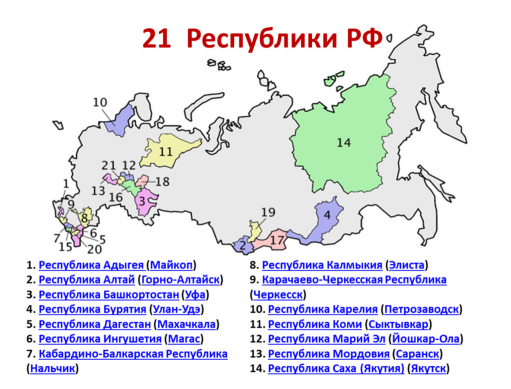


Статья 69 (сходство: 0.24):
1. Российская Федерация гарантирует права коренных малочисленных народов в соответствии с общепризнанными принципами и нормами международного права и международными договорами Российской Федерации. 2. Государство защищает культурную самобытность всех народов и этнических общностей Российской Федерации, гарантирует сохранение этнокультурного и языкового многообразия. 3. Российская Федерация оказывает поддержку соотечественникам, проживающим за рубежом, в осуществлении их прав, обеспечении защиты их интересов и сохранении общероссийской культурной идентичности.


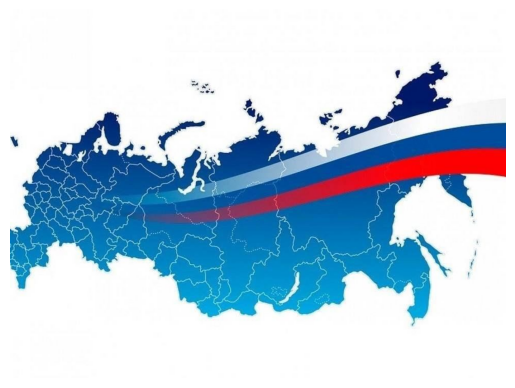


Статья 35 (сходство: 0.24):
1. Право частной собственности охраняется законом. 2. Каждый вправе иметь имущество в собственности, владеть, пользоваться и распоряжаться им как единолично, так и совместно с другими лицами. 3. Никто не может быть лишен своего имущества иначе как по решению суда. Принудительное отчуждение имущества для государственных нужд может быть произведено только при условии предварительного и равноценного возмещения. 4. Право наследования гарантируется.


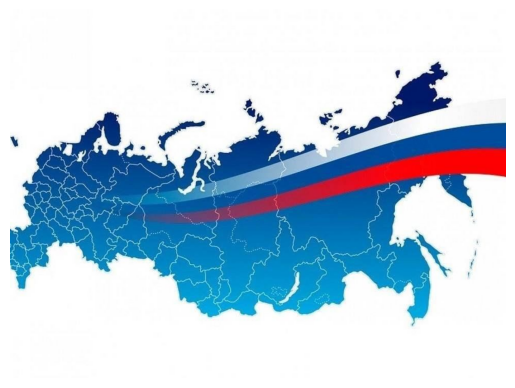

In [112]:
# Путь к загруженной картинке
user_image_path = "D:/pypy/pdf_search/images/st_25.jpg"  # Замени на реальный путь


# Поиск статей по картинке с использованием sklearn
results = search_by_image_sklearn(user_image_path)

# Вывод результатов
print("\nРезультаты поиска по картинке (sklearn):")
for title, text, image_path, similarity in results:
    print(f"\n{title} (сходство: {similarity:.2f}):\n{text}")
    if image_path:
        try:
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.axis("off")  # Скрыть оси
            plt.show()
        except FileNotFoundError:
            print(f"Ошибка: Картинка по пути '{image_path}' не найдена.")
        except Exception as e:
            print(f"Ошибка при загрузке картинки: {e}")
    else:
        print("Картинка не найдена")

При поиске по картинке со зданием нашлись, статьи про частную собственность, что собственно неплохо


Результаты поиска по картинке (sklearn):

Статья 24 (сходство: 0.26):
1. Сбор, хранение, использование и распространение информации о частной жизни лица без его согласия не допускаются. 2. Органы государственной власти и органы местного самоуправления, их должностные лица обязаны обеспечить каждому возможность ознакомления с документами и материалами, непосредственно затрагивающими его права и свободы, если иное не предусмотрено законом.


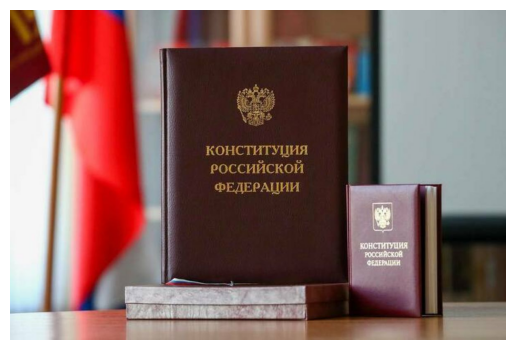


Статья 124 (сходство: 0.26):
Финансирование судов производится только из федерального бюджета и должно обеспечивать возможность полного и независимого осуществления правосудия в соответствии с федеральным законом.


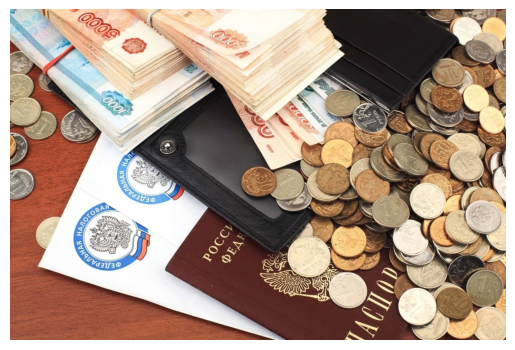


Статья 113 (сходство: 0.26):
Председатель Правительства Российской Федерации в соответствии с Конституцией Российской Федерации, федеральными законами, указами, распоряжениями, поручениями Президента Российской Федерации организует работу Правительства Российской Федерации. Председатель Правительства Российской Федерации несет персональную ответственность перед Президентом Российской Федерации за осуществление возложенных на Правительство Российской Федерации полномочий.


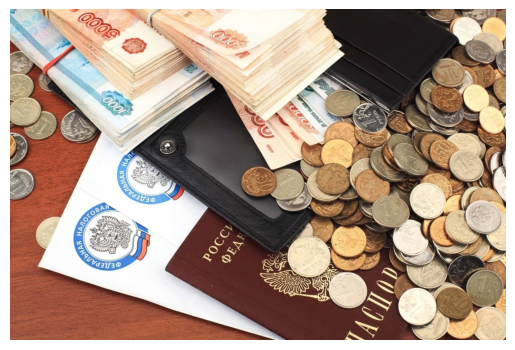

In [122]:
user_image_path = "D:/pypy/pdf_search/images/st_57.jpg"  # Замени на реальный путь


# Поиск статей по картинке с использованием sklearn
results = search_by_image_sklearn(user_image_path)

# Вывод результатов
print("\nРезультаты поиска по картинке (sklearn):")
for title, text, image_path, similarity in results:
    print(f"\n{title} (сходство: {similarity:.2f}):\n{text}")
    if image_path:
        try:
            img = mpimg.imread(image_path)
            plt.imshow(img)
            plt.axis("off")  # Скрыть оси
            plt.show()
        except FileNotFoundError:
            print(f"Ошибка: Картинка по пути '{image_path}' не найдена.")
        except Exception as e:
            print(f"Ошибка при загрузке картинки: {e}")
    else:
        print("Картинка не найдена")

По фото денег, нашли статьи которым присвоены те-же картинки, и речь идём про финансирование

In [124]:
import sys
print(sys.executable)

d:\pypy\venv\Scripts\python.exe


In [127]:
from huggingface_hub import hf_hub_download

# Скачиваем модель CLIP
model_path = hf_hub_download(repo_id="openai/clip-vit-base-patch32", filename="pytorch_model.bin")
print(model_path)

C:\Users\Ярослав\.cache\huggingface\hub\models--openai--clip-vit-base-patch32\snapshots\3d74acf9a28c67741b2f4f2ea7635f0aaf6f0268\pytorch_model.bin
